In [1]:
import pandas as pd
import numpy as np
from gensim.models import word2vec
from sklearn.manifold import TSNE
import plotly_express as px

In [2]:
class W2VExplorer:
    
    w2v_min_count:int = 10
    w2v_workers:int = 4
    w2v_size:int = 256
    w2v_window:int = 2
    tsne_perplexity:int = 40
    tsne_n_components:int = 2
    tsne_init:str = 'pca'
    tsne_n_iter:int = 2500
    tsne_random_state:int = 23
        
    
    def __init__(self, tokens, bag):
        self.TOKENS:pd.DataFrame = tokens
        self.BAG = bag
        
    def generate_model(self):
        print("Bag:", self.BAG[-1])
        print('Getting DOCS')
        self._get_docs()
        print("Getting MODEL")
        self._get_model()
        print("Getting tSNE Coords")
        self._get_tsne_coords()
        print(u'\u2713')
        return self
        
    def _get_docs(self):
        """Create a list of documents for Gensim"""
        self.DOCS = self.TOKENS.groupby(self.BAG)\
            .term_str.apply(lambda  x:  x.tolist())\
            .reset_index()['term_str'].tolist()
        
    def _get_model(self):
        """Run word2vec again the docs"""
        self.model = word2vec.Word2Vec(self.DOCS, 
                                 vector_size = self.w2v_size, 
                                 window = self.w2v_window, 
                                 min_count = self.w2v_min_count, 
                                 workers = self.w2v_workers)

    def _get_tsne_coords(self):
        # self.coords = pd.DataFrame(index=range(len(self.model.wv.vocab))) # Gensim 3
        self.coords = pd.DataFrame(index=range(len(self.model.wv)))
        # self.coords['label'] = [w for w in self.model.wv.vocab] # Gensim 3
        self.coords['label'] = [w for w in self.model.wv.key_to_index]
        self.coords['vector'] = self.coords['label'].apply(lambda x: self.model.wv.get_vector(x))
        self.tsne_model = TSNE(perplexity = 40, 
                               n_components = self.tsne_n_components, 
                               init = self.tsne_init, 
                               n_iter = self.tsne_n_iter, 
                               random_state = self.tsne_random_state)
        # self.tsne_values = self.tsne_model.fit_transform(self.coords['vector'].tolist())
        self.tsne_values = self.tsne_model.fit_transform(np.array(self.coords['vector'].to_list()))
        self.coords['x'] = self.tsne_values[:,0]
        self.coords['y'] = self.tsne_values[:,1]
        
    def plot_tsne(self):
        px.scatter(self.coords, 'x', 'y', text='label', height=1000)\
            .update_traces(mode='text').show()
        
    def complete_analogy(self, A, B, C, n=2):
        try:
            cols = ['term', 'sim']
            return pd.DataFrame(self.model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
        except KeyError as e:
            print('Error:', e)
            return None

    def get_most_similar(self, positive, negative=None):
        return pd.DataFrame(self.model.wv.most_similar(positive, negative), columns=['term', 'sim']) 

In [3]:
TOKENS = pd.read_csv("data/CORPUS.csv").set_index(['book_num', 'chap_num'])

In [4]:
w2v = W2VExplorer(TOKENS, ['book_num', 'chap_num'])

In [5]:
w2v.generate_model()

Bag: chap_num
Getting DOCS
Getting MODEL
Getting tSNE Coords
✓


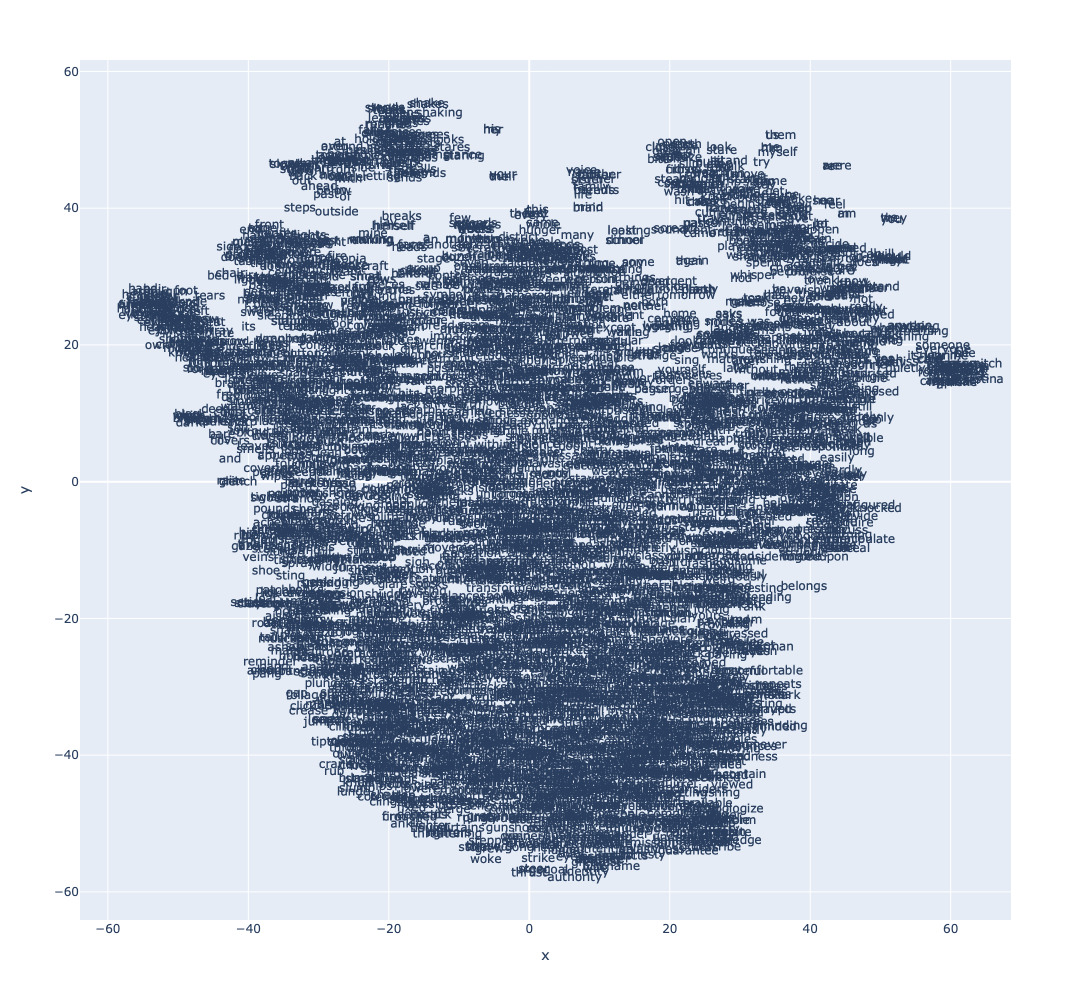

In [6]:
w2v.plot_tsne()

In [7]:
def get_vector(row):
    w = row.name
    try:
        vec = w2v.model.wv[w]
    except KeyError as e:
        vec = None
    return vec

In [8]:
VOCAB = pd.read_csv("data/VOCAB.csv").set_index('term_str')

In [9]:
WV = pd.DataFrame(VOCAB.apply(get_vector, axis=1).dropna()).apply(lambda x: pd.Series(x[0]), axis=1)

In [10]:
WV

0         1         2         3         4         5    \
term_str                                                               
00       -0.035606 -0.155047  0.003191  0.146322  0.101202 -0.015880   
1        -0.016639 -0.203680  0.002736  0.158874  0.195250 -0.056607   
7        -0.006713 -0.155603  0.005114  0.129498  0.120956 -0.029531   
a        -0.840992 -0.418042  0.046029 -0.183830  0.431848 -0.103488   
abandon  -0.030962 -0.111775 -0.018076  0.110516  0.089555 -0.026236   
...            ...       ...       ...       ...       ...       ...   
yours     0.016743 -0.140556  0.046790  0.093928  0.110709 -0.036014   
yourself  0.038352 -0.208585  0.206195 -0.115405  0.159879 -0.038557   
zeke      0.250701 -0.221248  0.216481  0.500182  0.488460  0.077900   
zip      -0.067662 -0.124966 -0.013199  0.183661  0.075273 -0.013677   
zoe       0.102608 -0.244855  0.170449  0.231785  0.270221 -0.027387   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
00        0.023032 -0.062940 -0.050845  0.071853  ...  0.073089  0.002419   
1        -0.017909 -0.089400 -0.019623  0.143579  ...  0.128831  0.007252   
7         0.030165 -0.098444 -0.030563  0.081889  ...  0.072403 -0.011379   
a        -0.093629  0.113056  0.066707  0.328196  ...  0.145137  0.005629   
abandon   0.011788 -0.067842 -0.029127  0.063210  ...  0.094561  0.015866   
...            ...       ...       ...       ...  ...       ...       ...   
yours     0.025573 -0.126466 -0.005499  0.099492  ...  0.054599 -0.003384   
yourself -0.064043 -0.018238  0.041166  0.222151  ...  0.204965 -0.097345   
zeke     -0.042653 -0.109347  0.053913  0.224278  ...  0.085500  0.122634   
zip       0.007818 -0.020087 -0.042289  0.073029  ...  0.157006  0.052757   
zoe      -0.029964 -0.152873 -0.009121  0.219960  ...  0.086275  0.017272   

               248       249       250       251       252       253  \
term_str                                                               
00       -0.019735 -0.019163 -0.062114  0.074926 -0.039889 -0.076040   
1        -0.064557 -0.020413 -0.051543  0.122290 -0.069916 -0.079071   
7        -0.059141 -0.021427 -0.061082  0.078495 -0.051362 -0.063829   
a         0.322067 -0.596861  0.208768  0.259112 -0.042019 -0.614789   
abandon  -0.022042 -0.037560 -0.062214  0.051709 -0.039502 -0.043786   
...            ...       ...       ...       ...       ...       ...   
yours    -0.078943 -0.026509 -0.094509  0.063469 -0.055936 -0.064276   
yourself -0.159135  0.027292 -0.062188  0.180789 -0.192703 -0.241428   
zeke     -0.143334 -0.011678 -0.228853  0.175926  0.098590 -0.240080   
zip      -0.010045 -0.052811 -0.056534  0.062414 -0.076006 -0.116251   
zoe      -0.144076 -0.052102 -0.168730  0.160393 -0.035601 -0.180687   

               254       255  
term_str                      
00       -0.086533  0.044813  
1        -0.091537  0.018838  
7        -0.093688  0.024238  
a        -0.502998  0.376723  
abandon  -0.082471  0.020002  
...            ...       ...  
yours    -0.057035  0.005386  
yourself -0.033303 -0.142345  
zeke     -0.028012  0.113164  
zip      -0.130851  0.017357  
zoe      -0.049892  0.057045  

[3922 rows x 256 columns]

In [11]:
WV.to_csv("data/VOCAB_W2V.csv")